In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import necessary libraries
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import drive
# Define dataset directory
data_dir = "/content/drive/My Drive/Normalized3/Final/"
# Function to load all CSV files from the directory
def load_data_from_drive(data_dir):
    files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]
    all_data = []
    labels = []

    for file in files:
        # Extract label from filename (0: murmur absent, 1: murmur present)
        label = 1 if "_1.csv" in file else 0

        # Read CSV file
        file_path = os.path.join(data_dir, file)
        df = pd.read_csv(file_path)

        # Ensure only MFCC features (52 features, ignoring header row)
        features = df.iloc[1:, :].values.astype(float)  # Exclude header row

        # Append to dataset
        all_data.append(features)
        labels.append(label)

    return np.array(all_data), np.array(labels)

# Load dataset
X, y = load_data_from_drive(data_dir)

X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Normalize feature values
scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])  # Flatten for scaling
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])  # Reshape back

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (131, 91, 52)
X_test shape: (33, 91, 52)
y_train shape: (131,)
y_test shape: (33,)


In [ ]:
# Define Positional Encoding Layer
class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
# Define the Multi-Head Dense Convolution Transformer Model
def build_model(input_shape, output_dim, num_encoder_layers=6):                             #Layers
    inputs = layers.Input(shape=input_shape)

    # Convolutional Feature Extraction
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dense(128, activation='relu')(x)

    # Positional Encoding
    pos_enc = PositionalEncoding(position=input_shape[0], d_model=128)
    x = pos_enc(x)

    # Transformer Encoder Blocks
    for _ in range(num_encoder_layers):
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)         #Heads
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization()(x)

    # Flatten & Output Layer
    x = layers.Flatten()(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model
# Reshape data to fit the model
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)


In [ ]:
# Build the model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
output_dim = 1
model = build_model(input_shape, output_dim)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])     #

# Model Summary
model.summary()

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=41, validation_data=(X_test_reshaped, y_test))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 91, 52)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 91, 64)    │     10,048 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 91, 64)    │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 45, 64)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 45, 128)   │      8,320 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 45, 128)   │          0 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 45, 128)   │    131,968 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 45, 128)   │          0 │ positional_encod… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 45, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 45, 128)   │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 45, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 45, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 45, 128)   │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 45, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 45, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 45, 128)   │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 45, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 45, 128)   │        256 │ add_3[0][0]     

 Total params: 829,825 (3.17 MB)

 Trainable params: 829,825 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 699ms/step - accuracy: 0.4263 - loss: 3.1919 - val_accuracy: 0.5455 - val_loss: 2.2485
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 0.5237 - loss: 2.1249 - val_accuracy: 0.4545 - val_loss: 1.2810
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 0.4424 - loss: 1.2026 - val_accuracy: 0.5455 - val_loss: 0.8017
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 714ms/step - accuracy: 0.5058 - loss: 0.7614 - val_accuracy: 0.5152 - val_loss: 0.6991
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step - accuracy: 0.5953 - loss: 0.6395 - val_accuracy: 0.5455 - val_loss: 0.6711
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step - accuracy: 0.6638 - loss: 0.5754 - val_accuracy: 0.5758 - val_loss: 0.6439
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.8318 - loss: 0.4523 - val_accuracy: 0.6364 - val_loss: 0.6525
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step - accuracy: 0.8493 - loss: 0.3759 - val_accuracy: 0.6364 - val_loss

In [ ]:
!pip install keras-flops


In [ ]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np

# Use one sample from your training input
sample_input = tf.convert_to_tensor(X_train_reshaped[:1], dtype=tf.float32)

# Get a concrete function from the Keras model
full_model = tf.function(lambda x: model(x))
concrete_func = full_model.get_concrete_function(tf.TensorSpec(sample_input.shape, sample_input.dtype))

# Convert Keras model to frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(concrete_func)
frozen_graph_def = frozen_func.graph.as_graph_def()

# Calculate FLOPs using TF profiler
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

profile_opts = ProfileOptionBuilder.float_operation()  # Count floating-point operations
flops_profile = profile(frozen_func.graph, options=profile_opts)

# Print FLOPs
flops = flops_profile.total_float_ops
print(f" Model FLOPs for input shape {sample_input.shape}: {flops:,} FLOPs")


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


 Model FLOPs for input shape (1, 91, 52, 1): 76,490,313 FLOPs


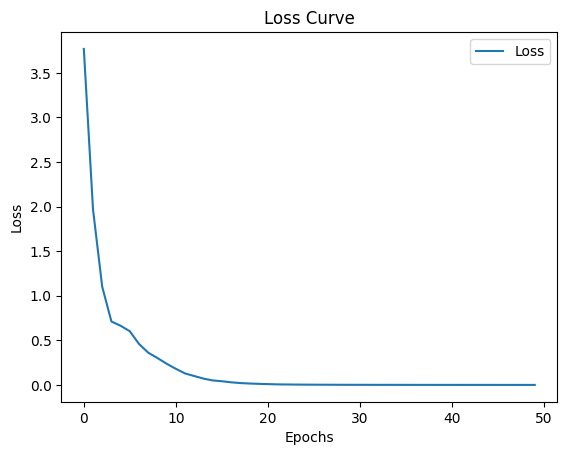

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step
Accuracy: 0.9207
Classification Report:

                precision    recall  f1-score   support

 Murmur Absent       0.90      0.95      0.93        87
Murmur Present       0.94      0.88      0.91        77

      accuracy                           0.92       164
     macro avg       0.92      0.92      0.92       164
  weighted avg       0.92      0.92      0.92       164



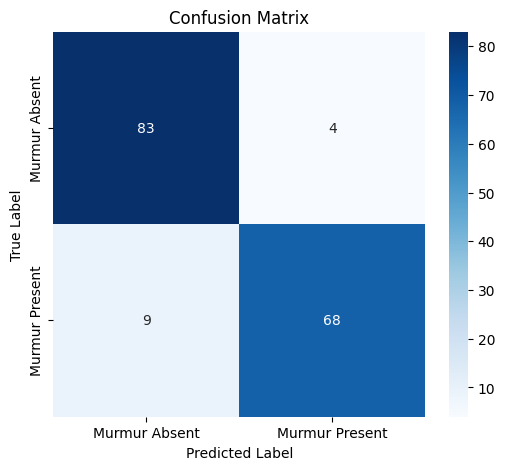

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions for the entire dataset
X_full = np.concatenate((X_train_reshaped, X_test_reshaped), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)

y_pred_probs = model.predict(X_full)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels

# Compute overall accuracy
overall_accuracy = accuracy_score(y_full, y_pred)
print(f'Accuracy: {overall_accuracy:.4f}')

# Print classification report
print("Classification Report:\n")
print(classification_report(y_full, y_pred, target_names=["Murmur Absent", "Murmur Present"]))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_full, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Murmur Absent", "Murmur Present"],
            yticklabels=["Murmur Absent", "Murmur Present"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Ensure X has the correct shape: (samples, timesteps, features)
X_full_reshaped = np.expand_dims(X, axis=-1)  # Adds channel dimension if missing

# Get predictions
y_pred_probs = model.predict(X_full_reshaped)
y_pred_tf = y_pred_probs.flatten()  # Convert to 1D array

# Save predictions
import os
import pickle

save_dir = "/content/drive/My Drive/stacking_preds/"
os.makedirs(save_dir, exist_ok=True)

file_path = os.path.join(save_dir, "Multi_Head.pkl")
with open(file_path, "wb") as f:
    pickle.dump(y_pred_tf, f)

print(f"Saved Keras model predictions for all {X.shape[0]} samples at: {file_path}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
Saved Keras model predictions for all 164 samples at: /content/drive/My Drive/stacking_preds/Multi_Head.pkl
